In [1]:
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

# Set backend with a fallback for numpy operations
backend = set_backend("torch_cuda", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image

import cortex
import torch

from AOTanalysis.voxelmotion.filter_info import FilterInfo

/tank/zhangs/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tank/zhangs/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
sub = 3
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside_old_Ycentered/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Ycentered_True_Xstd_True_testinside.joblib"
model = joblib.load(model_path)

In [3]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
# primal_coef /= np.linalg.norm(primal_coef, axis=0)[None]s
# primal_coef *= np.sqrt(np.maximum(0, scores))[None]
print("n_features, n_voxels) =", primal_coef.shape)



n_features, n_voxels) = (11845, 352914)


In [4]:
feature_number = primal_coef.shape[0]
voxel_number = primal_coef.shape[1]
filter_info = FilterInfo()
print("feature_numbe, voxel_number) =", feature_number, voxel_number)


average_polar_angles = np.zeros((voxel_number))
for i in range(voxel_number):
    # Ensure we're working with NumPy arrays
    voxel_coefs = primal_coef[:, i]
    #print("voxel_coefs.shape =", voxel_coefs.shape)
    
    # Check if we need to convert from PyTorch tensor to NumPy
    # import torch
    # if isinstance(voxel_coefs, torch.Tensor):
    #     voxel_coefs = voxel_coefs.detach().cpu().numpy()
    
    # # Now safely use NumPy functions
    # abs_sum = np.sum(np.abs(voxel_coefs))
    #use torch to calculate the sum
    abs_sum = torch.sum(torch.abs(torch.tensor(voxel_coefs))).item()
    voxel_coefs_normalized = voxel_coefs / abs_sum if abs_sum > 0 else np.zeros_like(voxel_coefs)
    
    # Calculate the average polar angle for this voxel
    average_polar_angle = 0
    for j in range(feature_number):
        # Get the polar angle for the j-th feature
        polar_angle = filter_info.index_to_polar_angle(j)
        
        # Update the average polar angle using the normalized coefficient
        average_polar_angle += voxel_coefs_normalized[j] * polar_angle
    
    # Store the average polar angle for this voxel
    average_polar_angles[i] = average_polar_angle

#convert to numpy array
average_polar_angles = np.array(average_polar_angles)
average_polar_angles_volume = reshape_from_flatten_masked_to_wholebrain(average_polar_angles, sub)
print("average_polar_angles_volume.shape =", average_polar_angles_volume.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
average_polar_angles_volume = np.transpose(average_polar_angles_volume, (2, 1, 0))
print("Transposed polar angles volume shape:", average_polar_angles_volume.shape)

glminfo = GLMSingleAccess()
affine = glminfo.read_affine(sub)
header = glminfo.read_header(sub)


# nifti_img = Nifti1Image(polar_angles_volume, affine=affine, header=header)
# nifti_img.to_filename(save_path / f"polar_angles_sub{sub}.nii.gz")

save_path = Path(f"/tank/shared/2024/visual/AOT/temp/motion_energy_analysis/motion2polar_average")
save_path.mkdir(parents=True, exist_ok=True)
nifti_img = Nifti1Image(average_polar_angles_volume, affine=affine, header=header)
nifti_img.to_filename(save_path / f"average_polar_angles_sub{sub}.nii.gz")



feature_numbe, voxel_number) = 11845 352914
average_polar_angles_volume.shape = (84, 95, 106)
Transposed polar angles volume shape: (106, 95, 84)


Caching mapper...
Unable to init server: Could not connect: Connection refused
** (inkscape:4034932): WARNING **: 00:30:41.341: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
** (inkscape:4034951): WARNING **: 00:30:41.867: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)


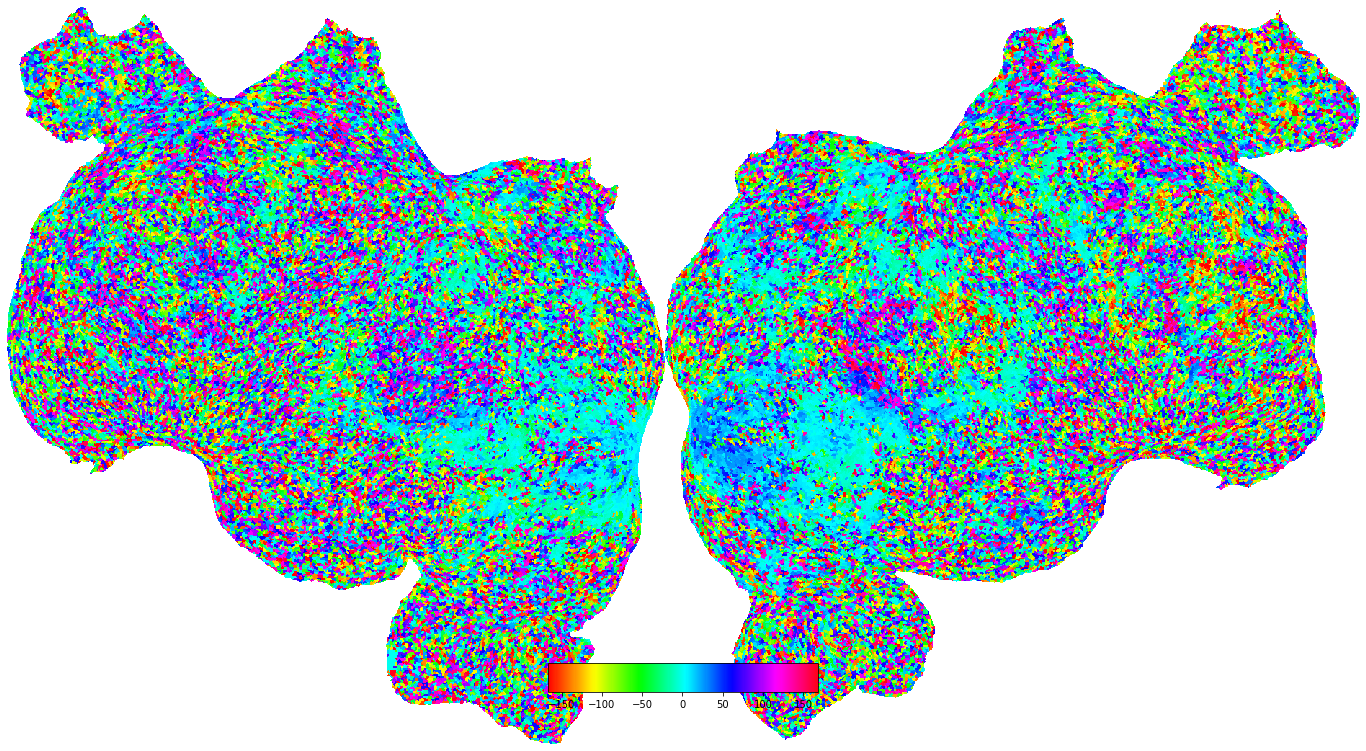

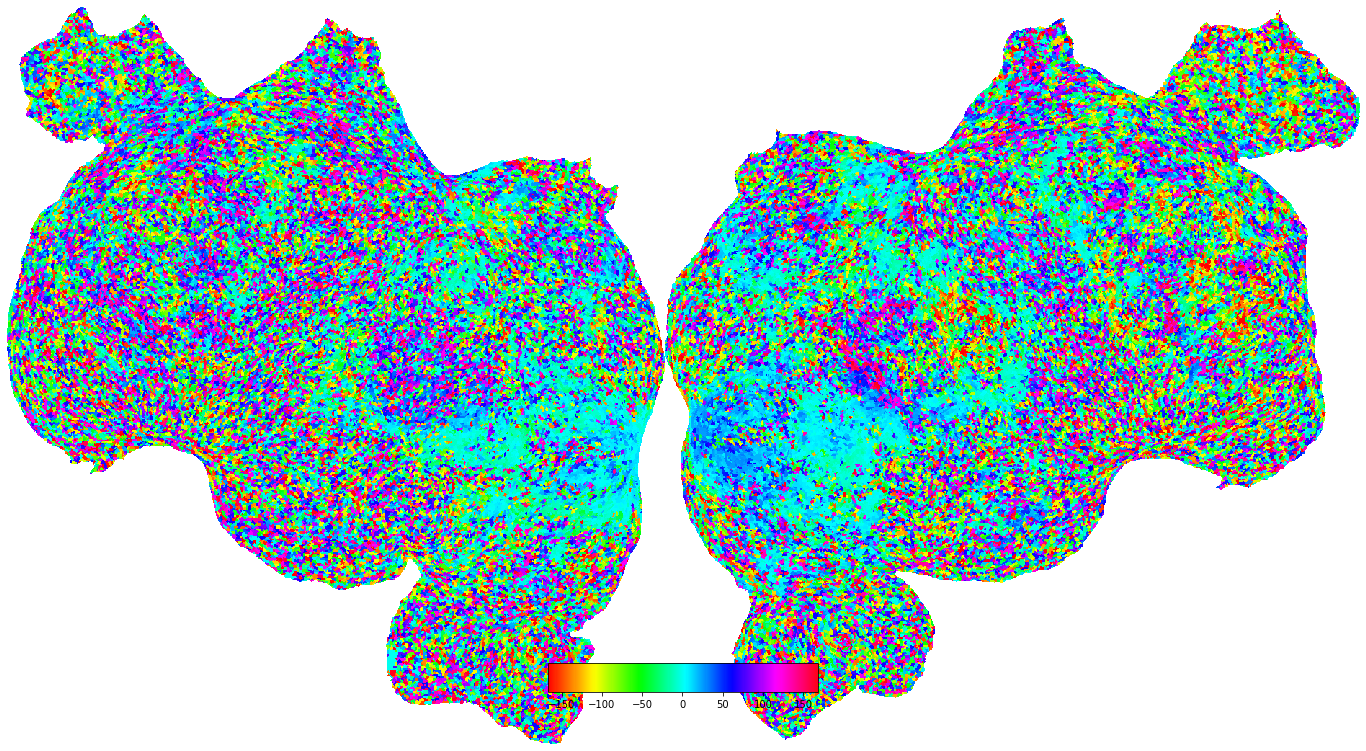

In [5]:
# Note: The polar_angles_volume has been transposed to match the expected shape for cortex.Volume
sub = "sub-003"
volume = cortex.Volume(average_polar_angles_volume, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

# Set colormap
selected_cmap = "hsv"  # Change this to your desired colormap
native_surface_map.cmap = selected_cmap

cortex.quickshow(
    native_surface_map,
    with_curvature=True,
    with_colorbar=True,
    with_labels=False,
    with_sulci=True,
    with_legend=False,
    cmap=selected_cmap,
    colorbar_label="Polar Angle",
)